## Presentation

A notebook to process BCDI data using cdiutils package and PyNX phase retrieval

In [2]:
import os
import hdf5plugin # if data are too large
from xrayutilities import en2lam

from cdiutils.processing.pipeline import BcdiPipeline
from cdiutils.load.authorized_keys import get_parameters_from_notebook_variables

## Processing parameters

In [73]:
metadata = {
  'beamline_setup': 'ID01BLISS',
  'scan': 14,
  'sample_name': 'B18S2P1_0005',
  'experiment_file_path': "/data/visitor/hc4959/id01/20230214/raw/hc4959_id01.h5",
  'detector_data_path': None, # for ID01SPEC setup
  'edf_file_template': None, # for ID01SPEC setup
  'detector_name': 'mpxgaas',
  'flatfield_path': None,
  "alien_mask": "/data/id01/inhouse/clatlan/experiments/gaas_hotpixel_mask.npz",
  'dump_dir': None,
  'reconstruction_file': "mode.h5"
}

metadata["dump_dir"] = (
    '/data/id01/inhouse/clatlan/experiments/hc4959/analysis'
    f'/results/{metadata["sample_name"]}/S{metadata["scan"]}/'
)

preprocessing_output_shape = [150, 150]
energy = 13000
roi = [0, 516, 0, 516]
hkl = [1, 1, 1]
det_reference_voxel_method = "max"
det_reference_voxel = None #[120, 327, 185]
binning_along_axis0 = None

det_calib_parameters = {
  'cch1': 142.1073219843305, # direct beam position vertical 
  'cch2': 84.82912663901058, # horizontal
  'pwidth1': 5.5e-05,
  'pwidth2': 5.5e-05,
  'distance': 1.190751708301797,
  'tiltazimuth': 304.59473739750683,
  'tilt': 377.7119313547357,
  'detrot': 0.7435897435897436,
  'outerangle_offset': 0.0
}

voxel_size = 10
apodize = True
flip = False
isosurface = None

usetex = True
show = True
verbose = True
debug = True

# PyNX parameters
data = (
  metadata["dump_dir"]
  + f"S{metadata['scan']}_pynx_input_data.npz"
)

mask = (
  metadata["dump_dir"]
  + f"S{metadata['scan']}_pynx_input_mask.npz"
)

data2cxi = True
auto_center_resize = True

support_type = "square"
support_size = (40, 20, 40)
support = "auto"
support_threshold = "0.30, 0.40"
support_threshold_method = "rms"
support_only_shrink = False
support_update_period = 20
support_smooth_width_begin = 2
support_smooth_width_end = 1
support_post_expand = "1,-2,1"
psf = "pseudo-voigt,0.5,0.1,10"

nb_raar = 1000
nb_hio = 150
nb_er = 150
nb_ml = 10
nb_run = 25
nb_run_keep = 10

zero_mask = False
crop_output = 0
positivity = False
beta = 0.9
detwin = False

rebin = "1,1,1"
detector_distance = det_calib_parameters["distance"]
pixel_size_detector = 55e-6
wavelength = float(en2lam(energy) * 1e-10) # wavelength in meter

verbose = 100
output_format = "cxi"
live_plot = False
save_plot = True
mpi = "run"


# Load the parameters and parse them into the BcdiPipeline instance 
parameters = get_parameters_from_notebook_variables(dir(), globals())
bcdi_pipeline = BcdiPipeline(parameters=parameters)

### Preprocess the data: crop and center the data


********************************************************************************
*   [INFO] Proceeding to preprocessing using the cdiutils backend (scan 14)    *
********************************************************************************

The preprocessing output shape is: (241, 150, 150)
Method employed for the reference voxel determination is max
Shape before checking: (241, 150, 150)
Shape after checking: (240, 150, 150)
[INFO]

Max in the full detector frame at (120, 358, 342)
Max in the cropped
detector frame at (120, 75, 75)
The max corresponds to a d-spacing of 2.0514 A
and a lattice parameter of 3.5531 A

Com in the full detector frame at (120.18,
358.04, 343.42) (based on a (150, 150) max-centered bounding box)
Com in the
cropped detector frame at (120.18, 75.04, 76.42)
The com corresponds to a
d-spacing of 2.0513 A and a lattice parameter of 3.5530 A

The reference
q_lab_reference corresponds to a d-spacing of 2.0514 A and a lattice parameter
of 3.5531 A

[INFO] Dump di

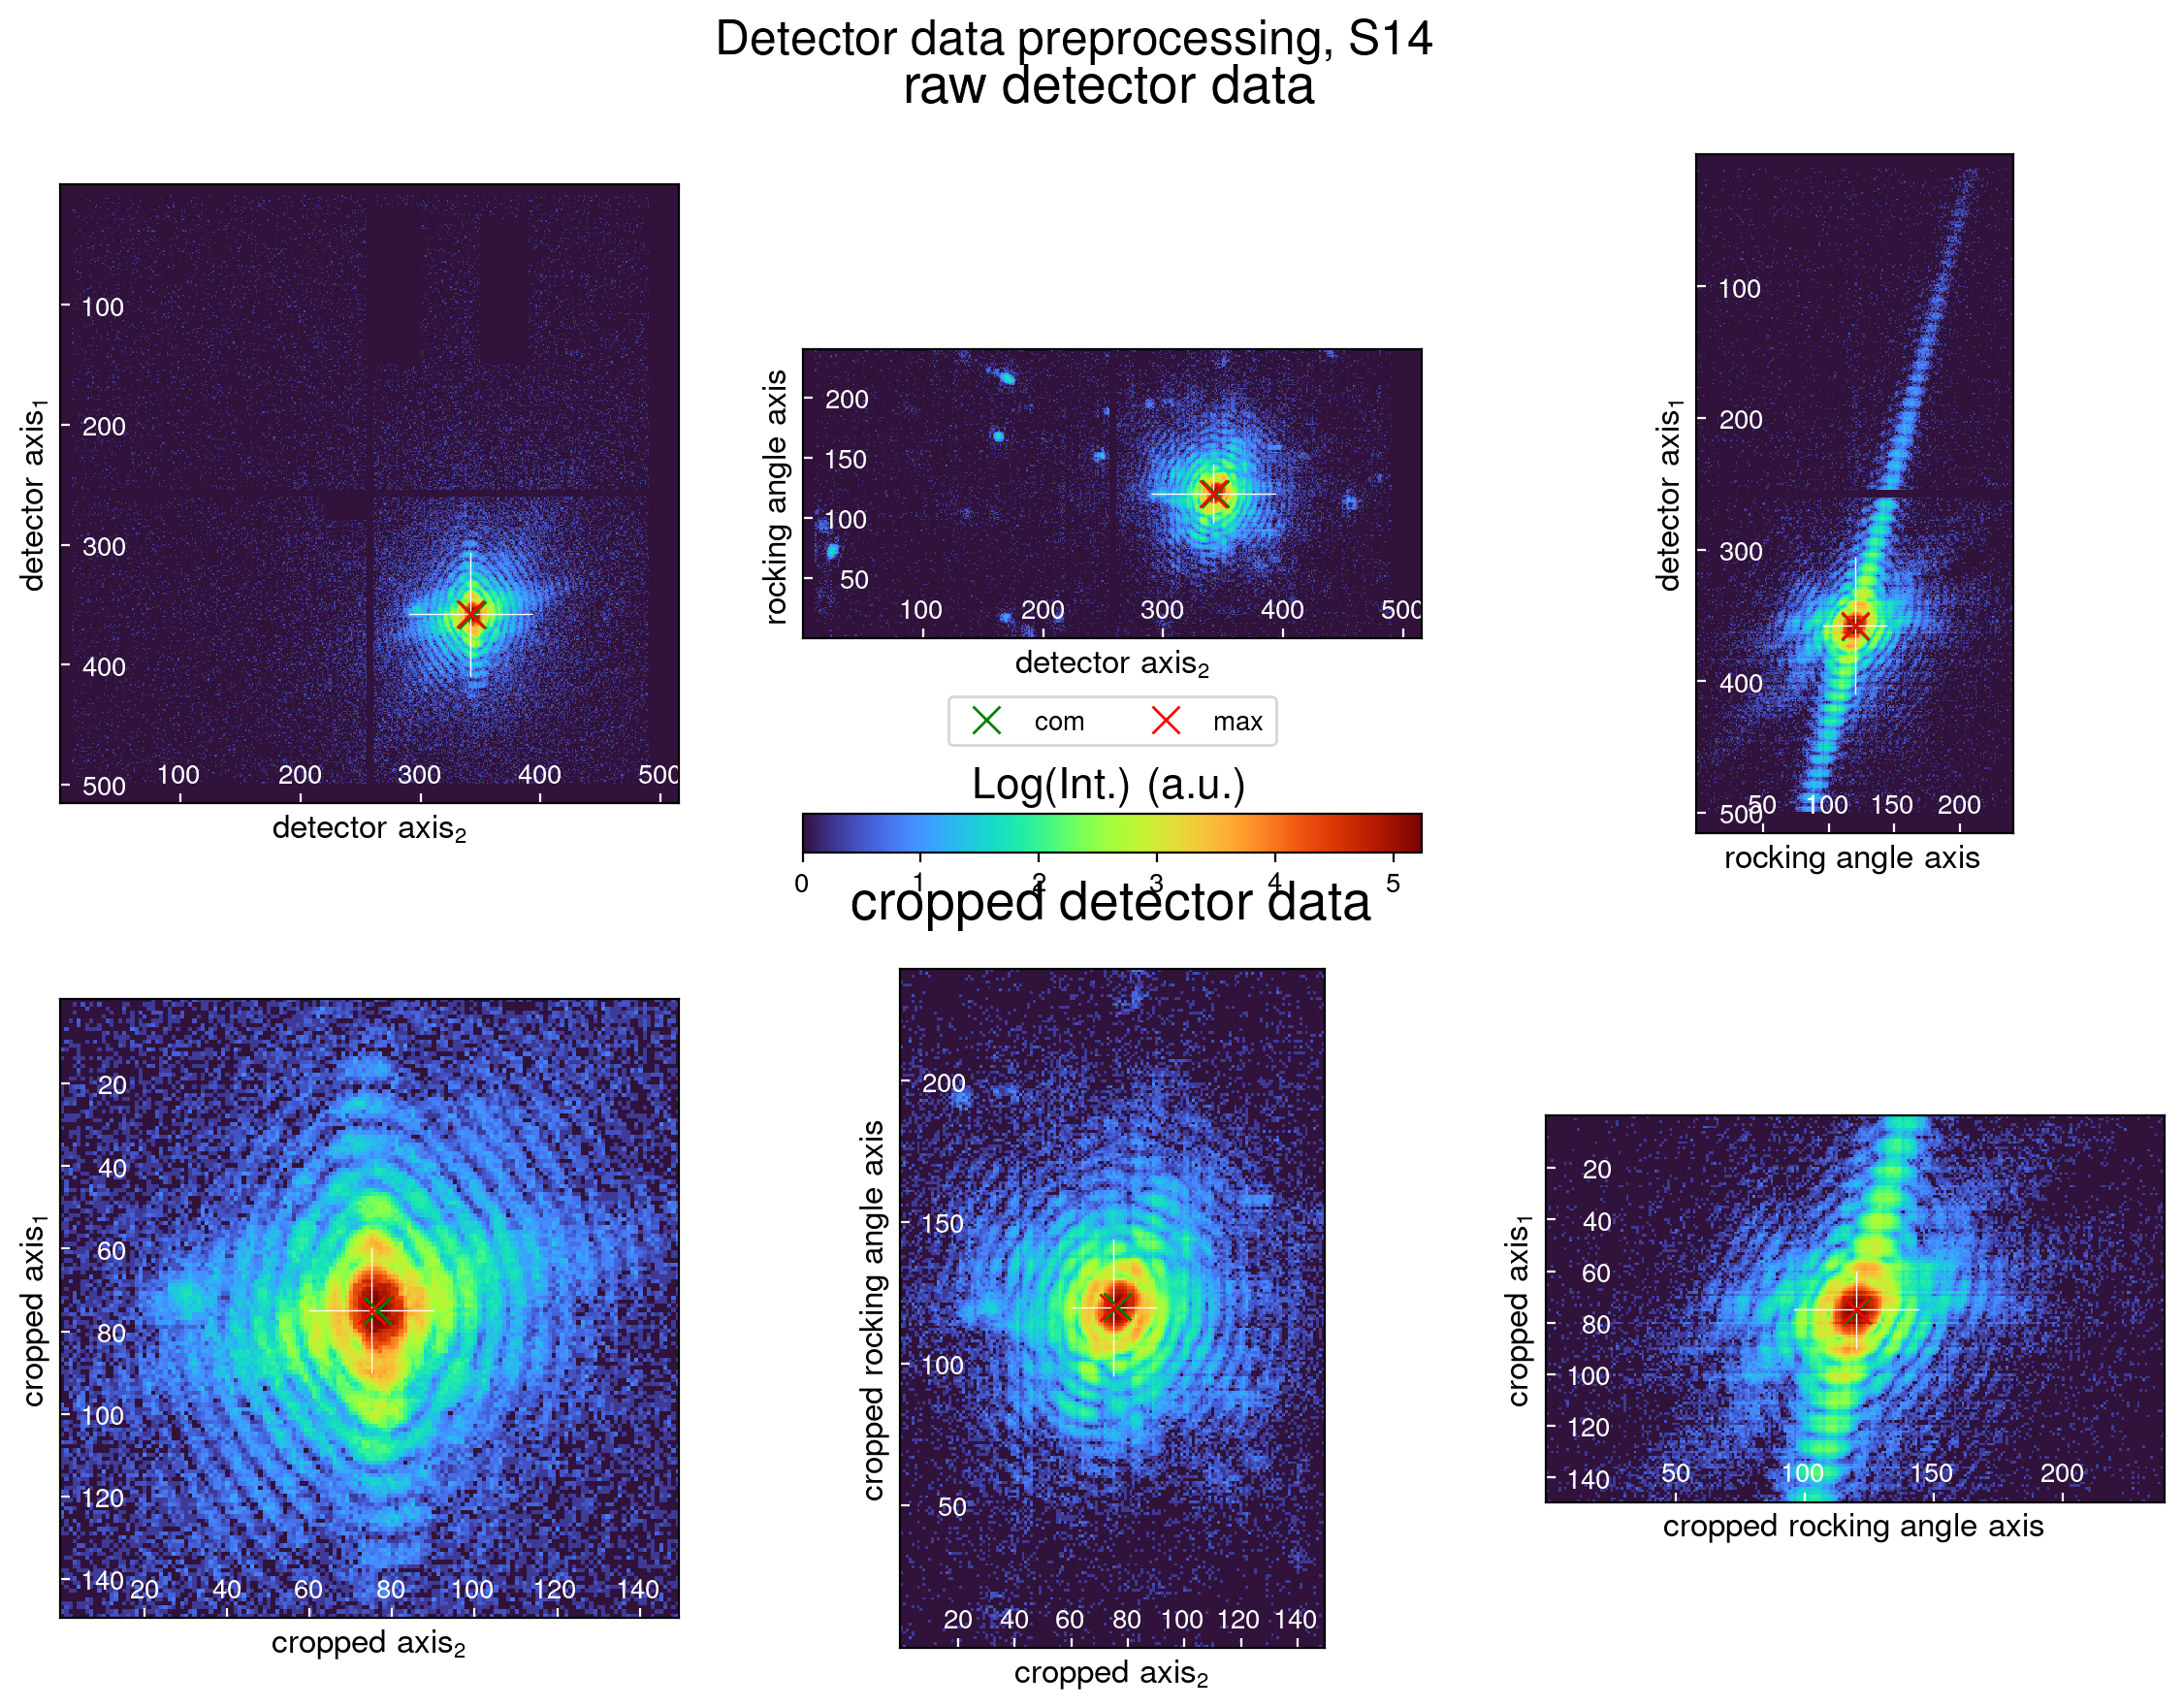


********************************************************************************
*Saving scan parameter file at the following location:
/data/id01/inhouse/clatlan/experiments/hc4959/analysis/results/B18S2P1_0005/S14/*
********************************************************************************



In [74]:
bcdi_pipeline.preprocess()

### Run PyNX phase retrieval using ESRF's p9 GPUs

In [75]:
user = os.environ["USER"]
key_file_path = os.environ["HOME"] + "/.ssh/id_rsa"
number_of_gpus = 1

print(
    f"Will use the user name '{user}' "
    f"and the private key file path: '{key_file_path}'"
)

bcdi_pipeline.phase_retrieval(
    # machine="slurm-nice-devel",
    machine="lid01pwr9",
    user=user,
    number_of_gpus=number_of_gpus,
    key_file_path=key_file_path,
    remove_last_results=True
)

Will use the user name 'atlan' and the private key file path: '/users/atlan/.ssh/id_rsa'

********************************************************************************
*             [INFO] Proceeding to PyNX phase retrieval (scan 14)              *
********************************************************************************

[INFO] Removing former results

[INFO] Connected to lid01pwr9
1  /sware/exp/pynx/activate_pynx.sh  
Activated pynx (version=2022.1) on Ubuntu-20.04-ppc64le: /sware/exp/pynx/2022.1/Ubuntu-20.04-ppc64le
--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: lid01pwr9
--------------------------------------------------------------------------
Using parameters file:  pynx-cdi-inputs.txt
auto_center_resize True

### Filter/sort the reconstructions and decompose them into one mode


In [76]:
bcdi_pipeline.find_best_candidates(nb_to_keep=5)
bcdi_pipeline.mode_decomposition()


********************************************************************************
*        [INFO] Finding the best candidates of the PyNX run. (scan 14)         *
********************************************************************************


[INFO] Candidates with the lowest mean_to_max will be saved.

[INFO] Opening file: S14_pynx_input_data-2023-02-15T11-02-17_Run0021_LLKf001.4844_LLK002.1592_SupportThreshold0.37971.cxi
[INFO] Opening file: S14_pynx_input_data-2023-02-15T11-00-02_Run0001_LLKf001.4993_LLK002.2030_SupportThreshold0.38313.cxi
[INFO] Opening file: S14_pynx_input_data-2023-02-15T11-00-28_Run0004_LLKf001.4598_LLK002.1087_SupportThreshold0.33953.cxi
[INFO] Opening file: S14_pynx_input_data-2023-02-15T11-01-51_Run0017_LLKf001.4021_LLK002.0621_SupportThreshold0.36844.cxi
[INFO] Opening file: S14_pynx_input_data-2023-02-15T11-02-30_Run0023_LLKf001.4091_LLK002.0899_SupportThreshold0.32386.cxi
[INFO] Opening file: S14_pynx_input_data-2023-02-15T11-01-32_Run0014_LLKf001.3634_

### Finally postprocess the data: orthogonalize, compute phase, dispacement, strain, dspacing...

(120.252485948984, 75.36215593024932, 72.16616227122064) (240, 150, 144) (114.252485948984, 76.36215593024932, 68.16616227122064)
[INFO] The shape of the reconstructed object is: (240, 150, 144)
The shape for a
safe centered cropping is: (240, 150, 144)
[INFO] Voxel size in the direct lab frame provided by user: 10 nm
[INFO] the extent in the target space of a regular grid defined in the original space with a shape of (240, 150, 144) is (272, 149, 152)
[INFO] Voxel size in the direct lab space due to the orthognolization process [ 9.78657522 14.76301066 14.60431872]
[INFO] the extent in the target space of a regular grid defined in the original space with a shape of (240, 150, 144) is (236, 219, 280)
[INFO] Voxel size finally used is: [10 10 10] nm in the CXI convention
[PROCESSING] Apodizing the complex array:done.
[PROCESSING] Finding an isosurface estimate based on the reconstructed Bragg
electron density histogram:done.
[INFO] isosurface estimated at 0.5498425168429434
[INFO] The t

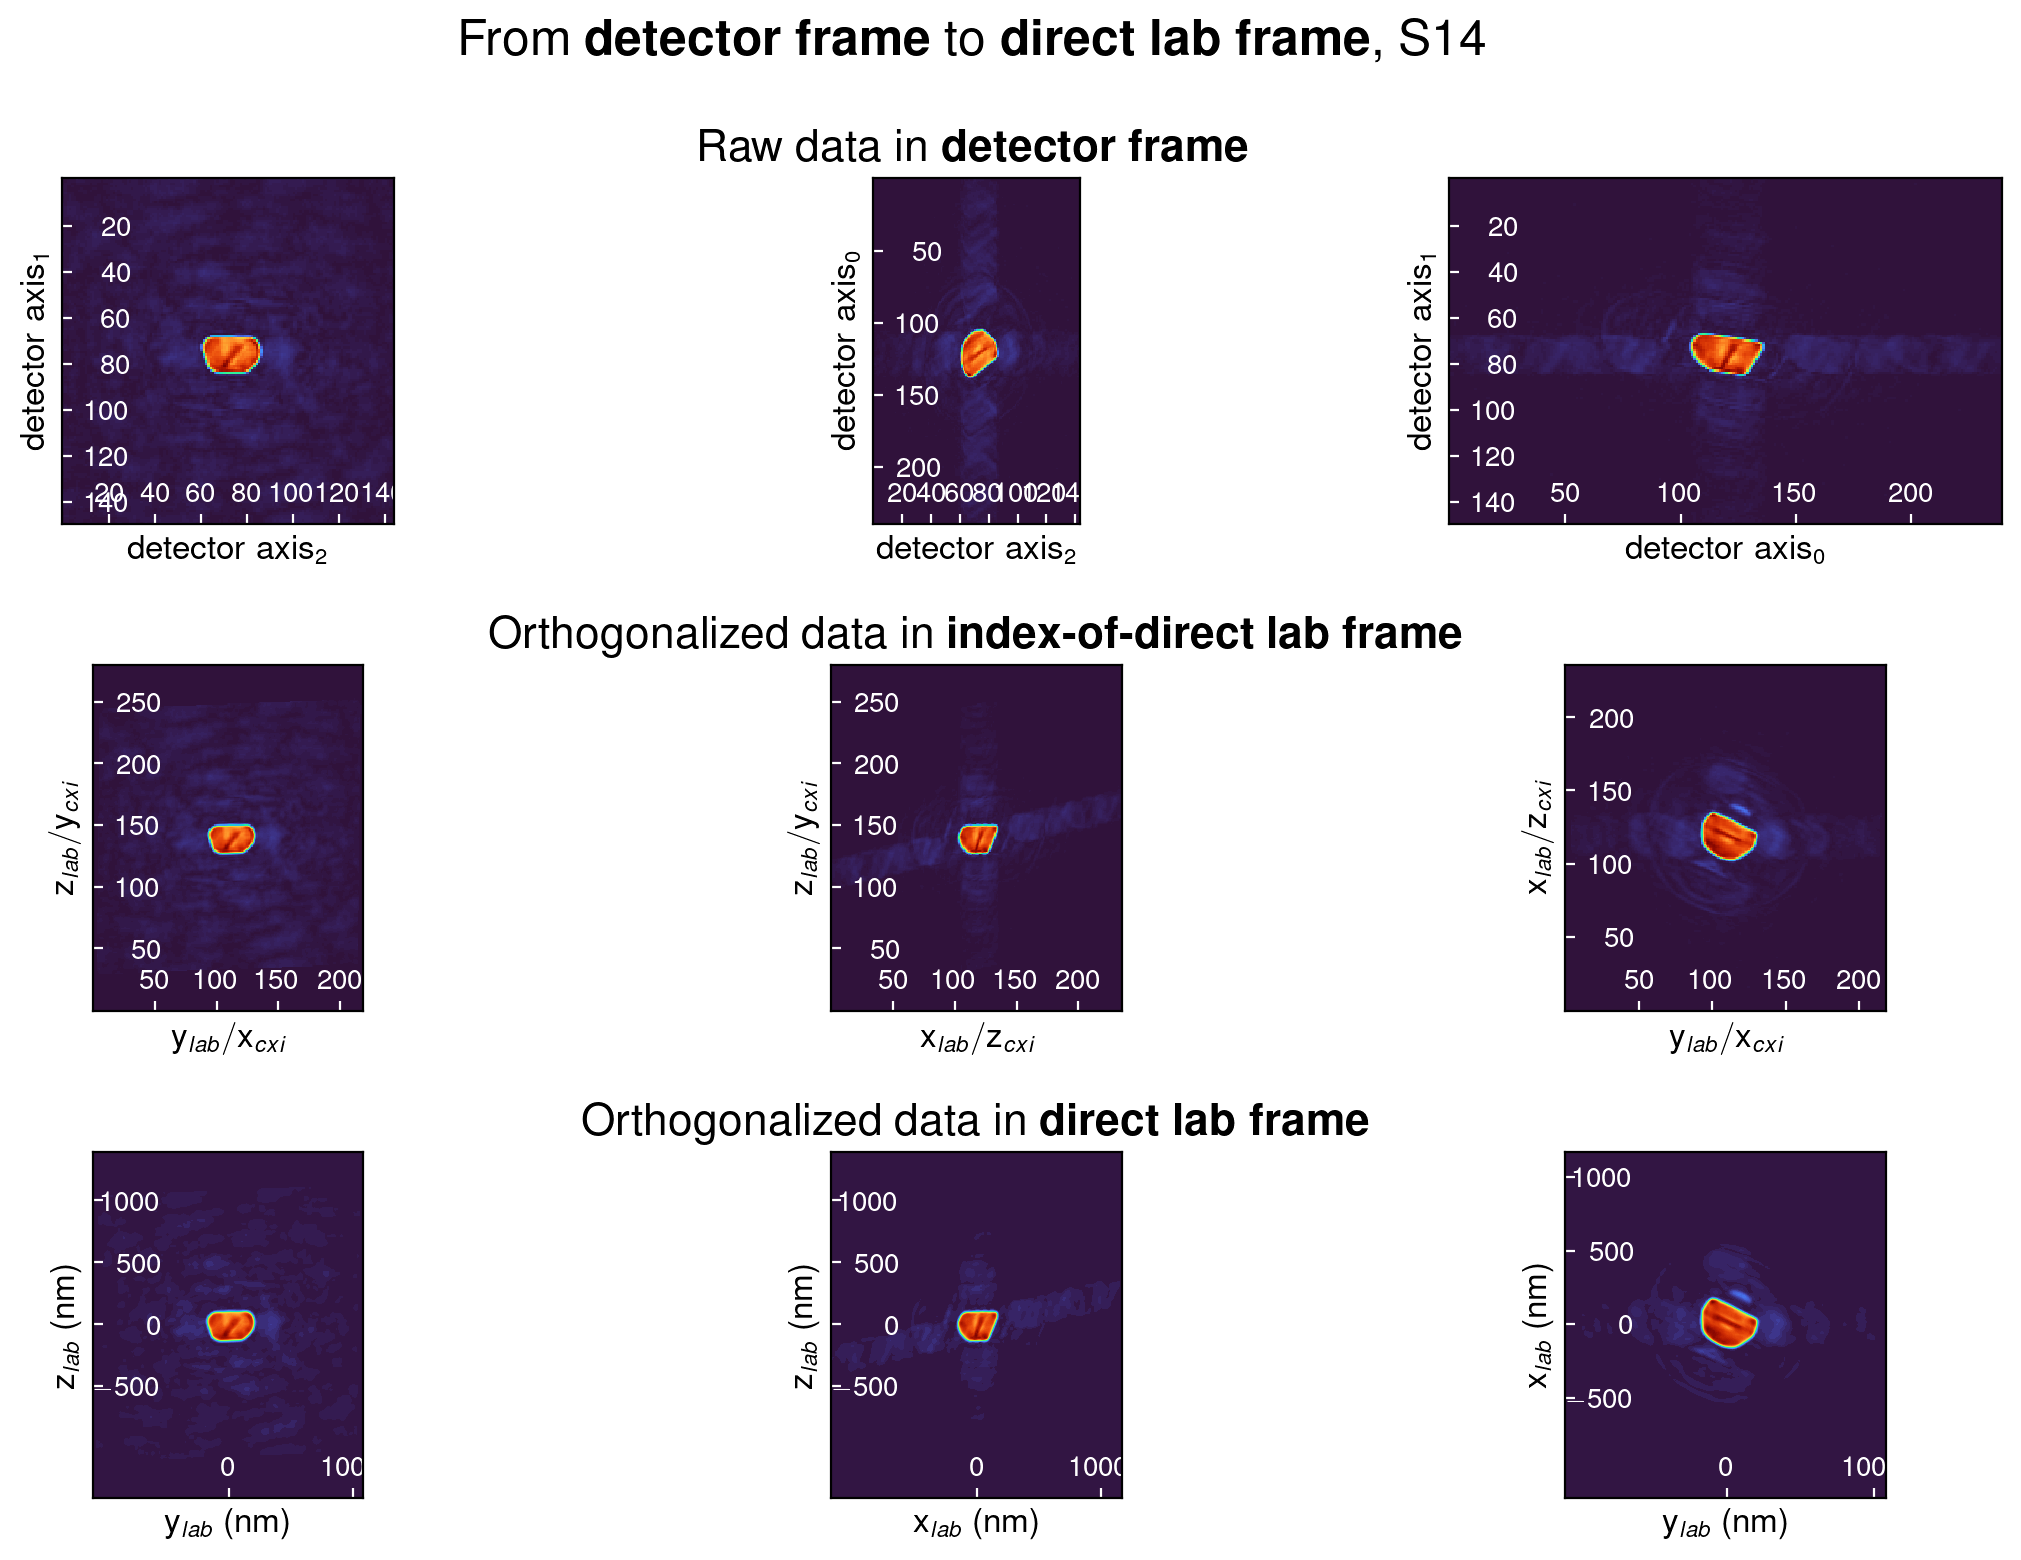

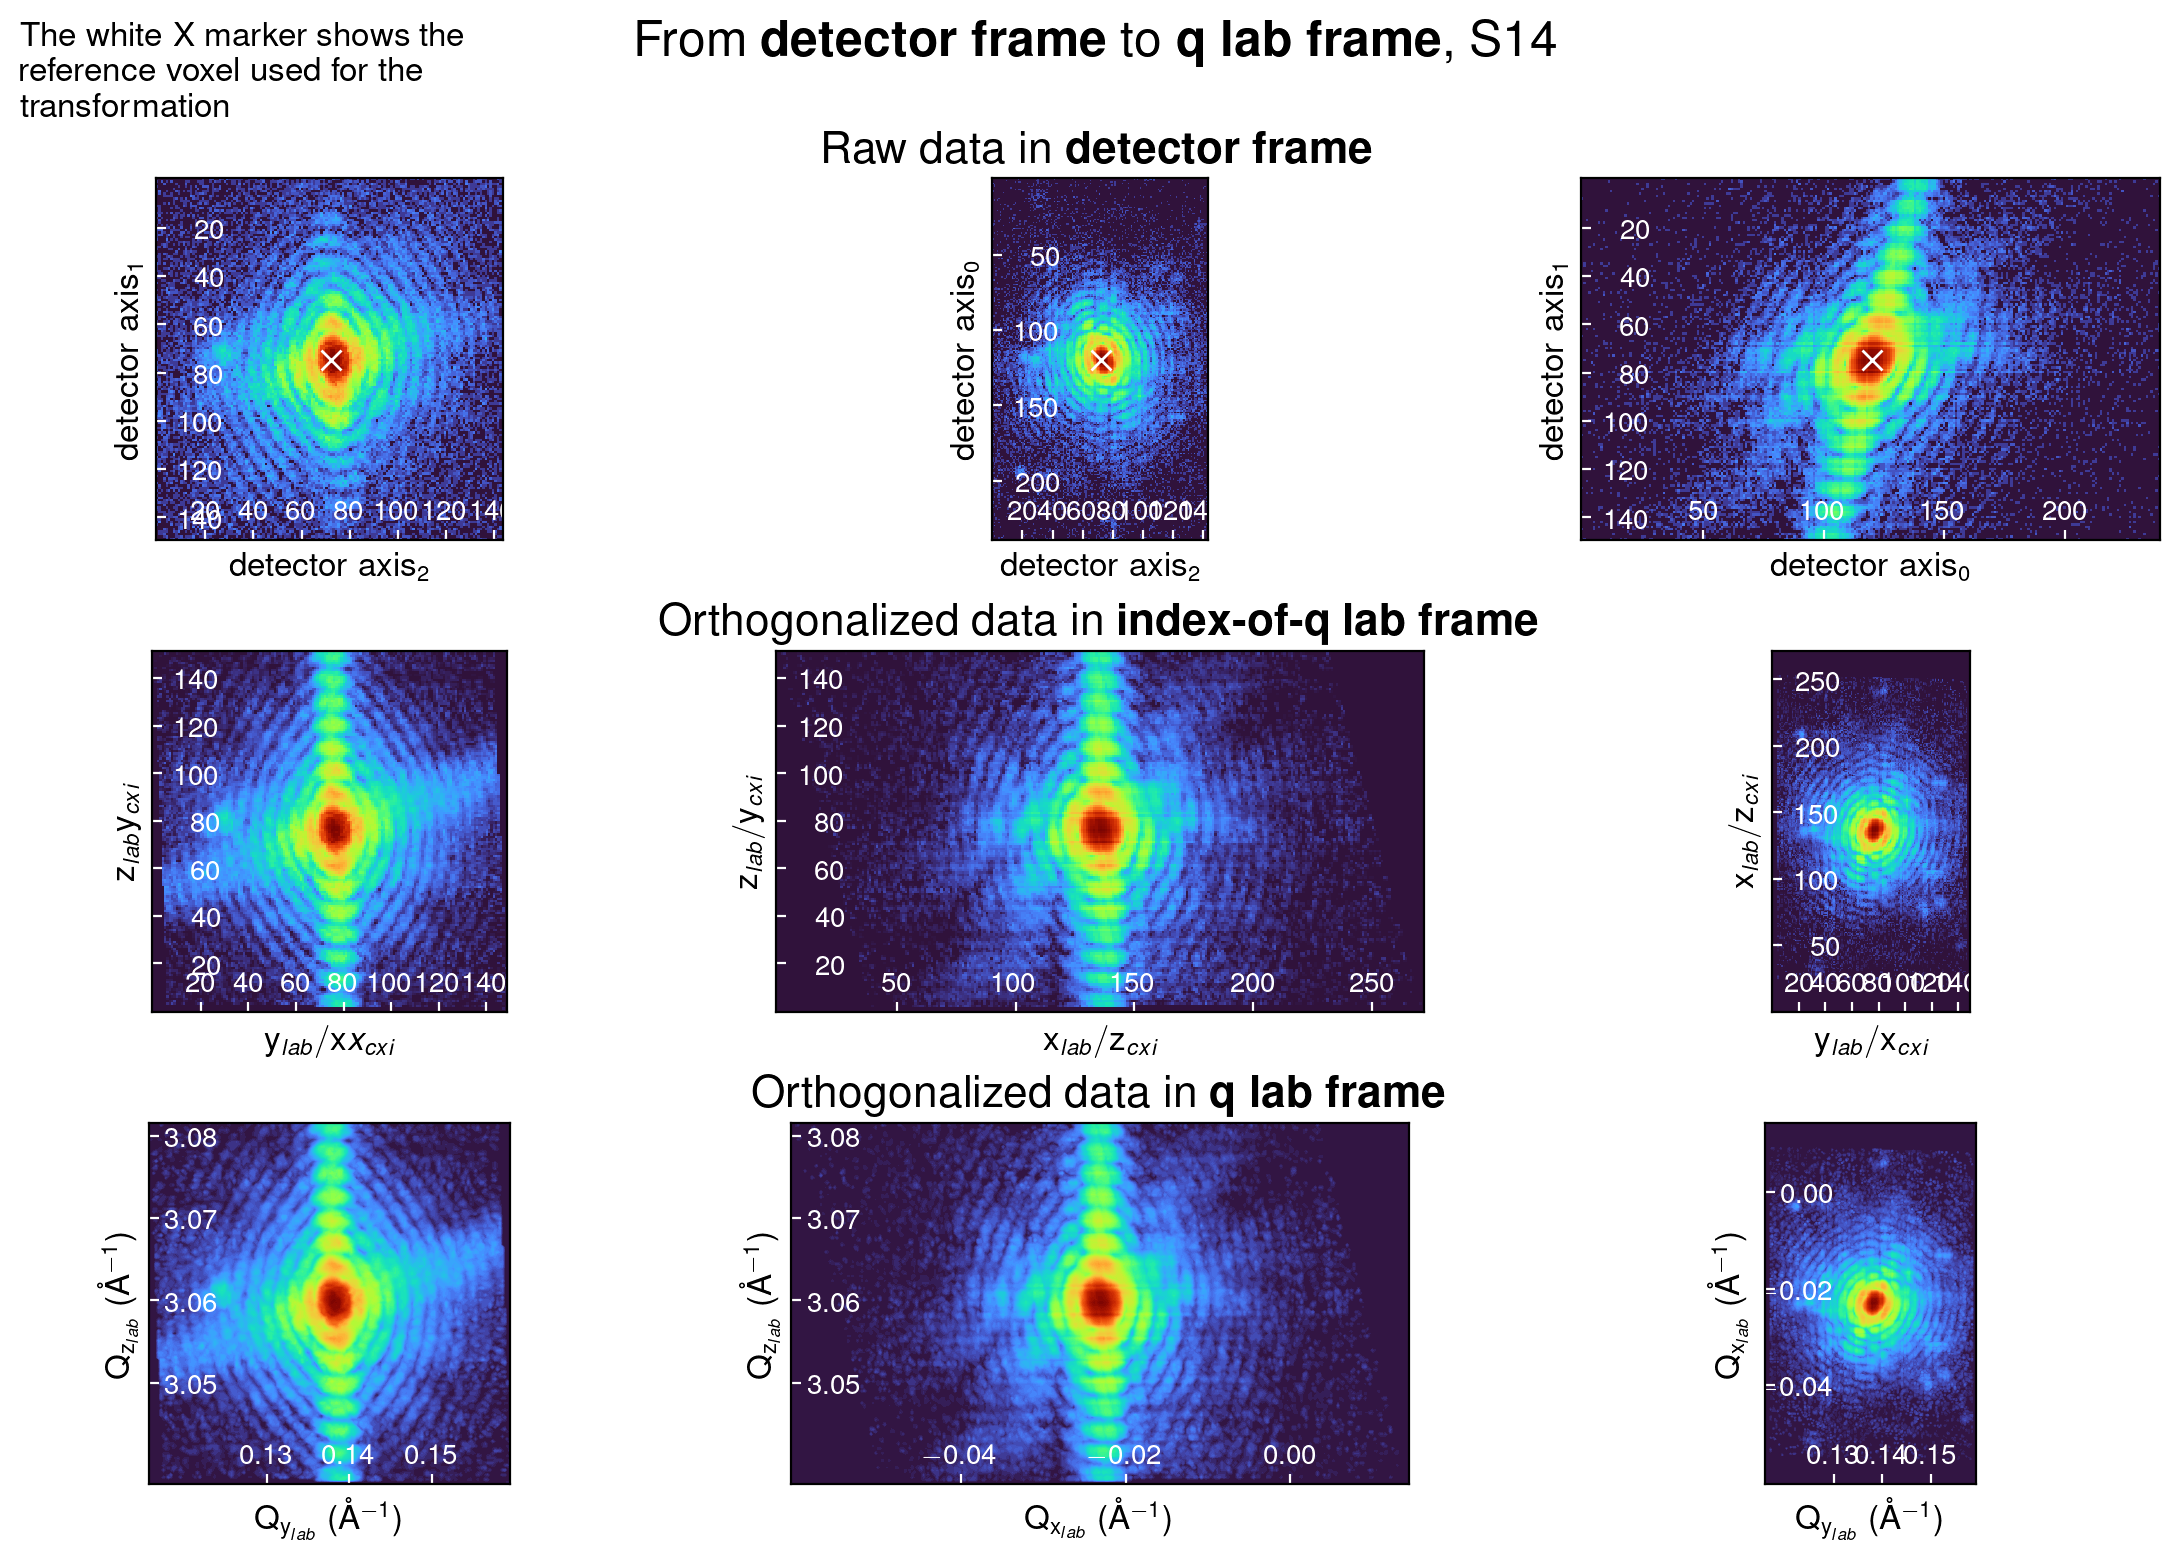

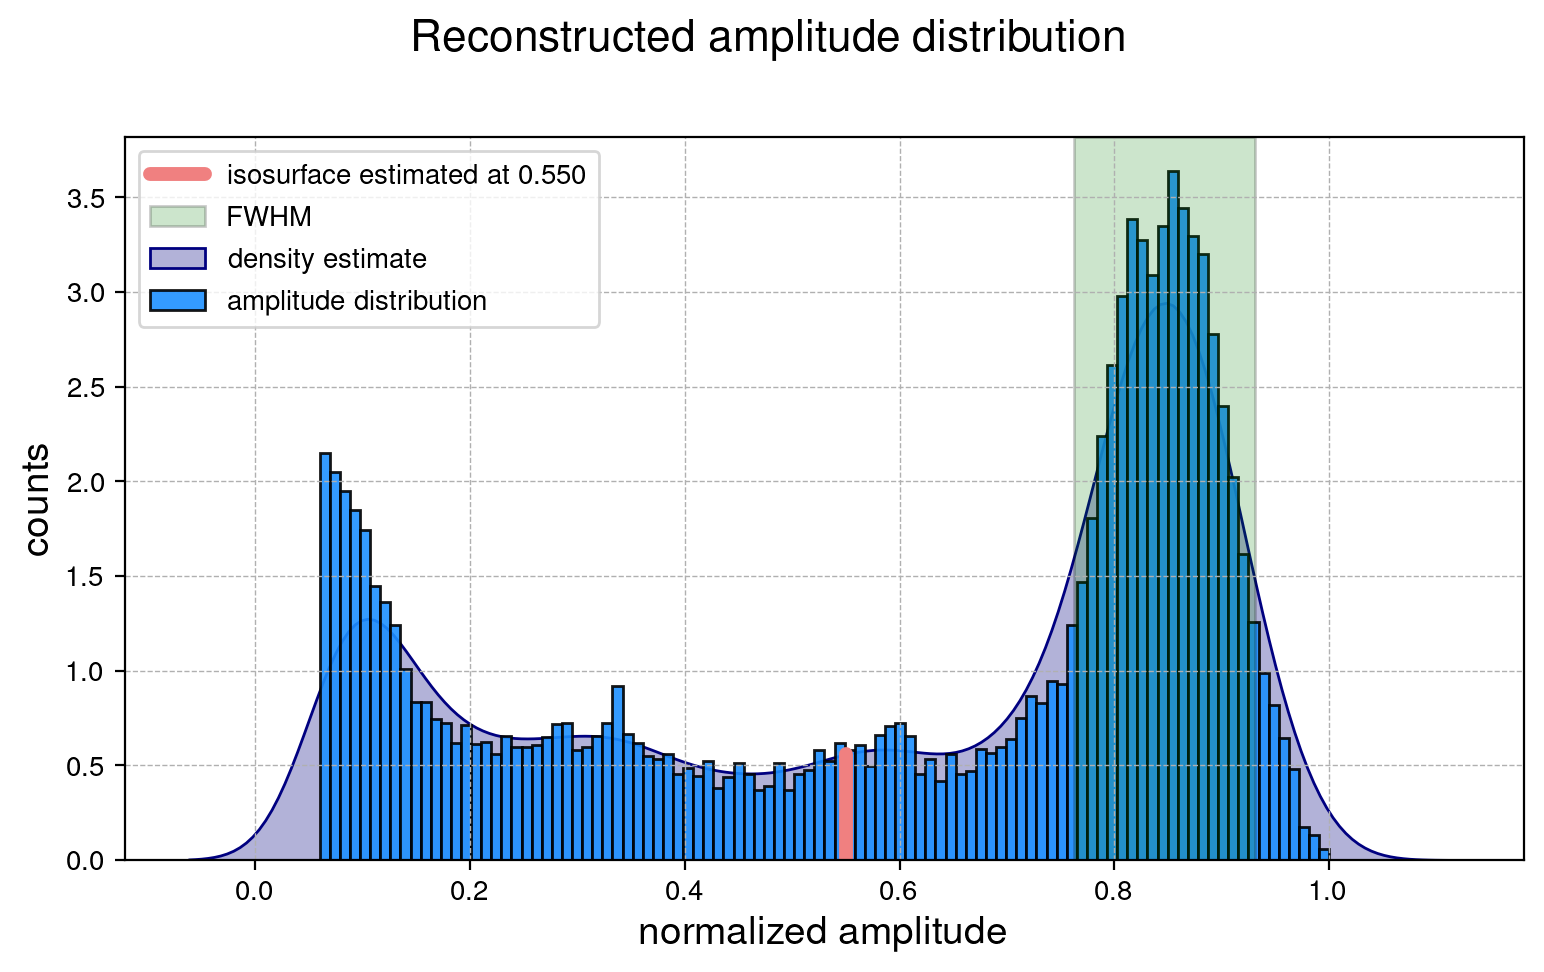

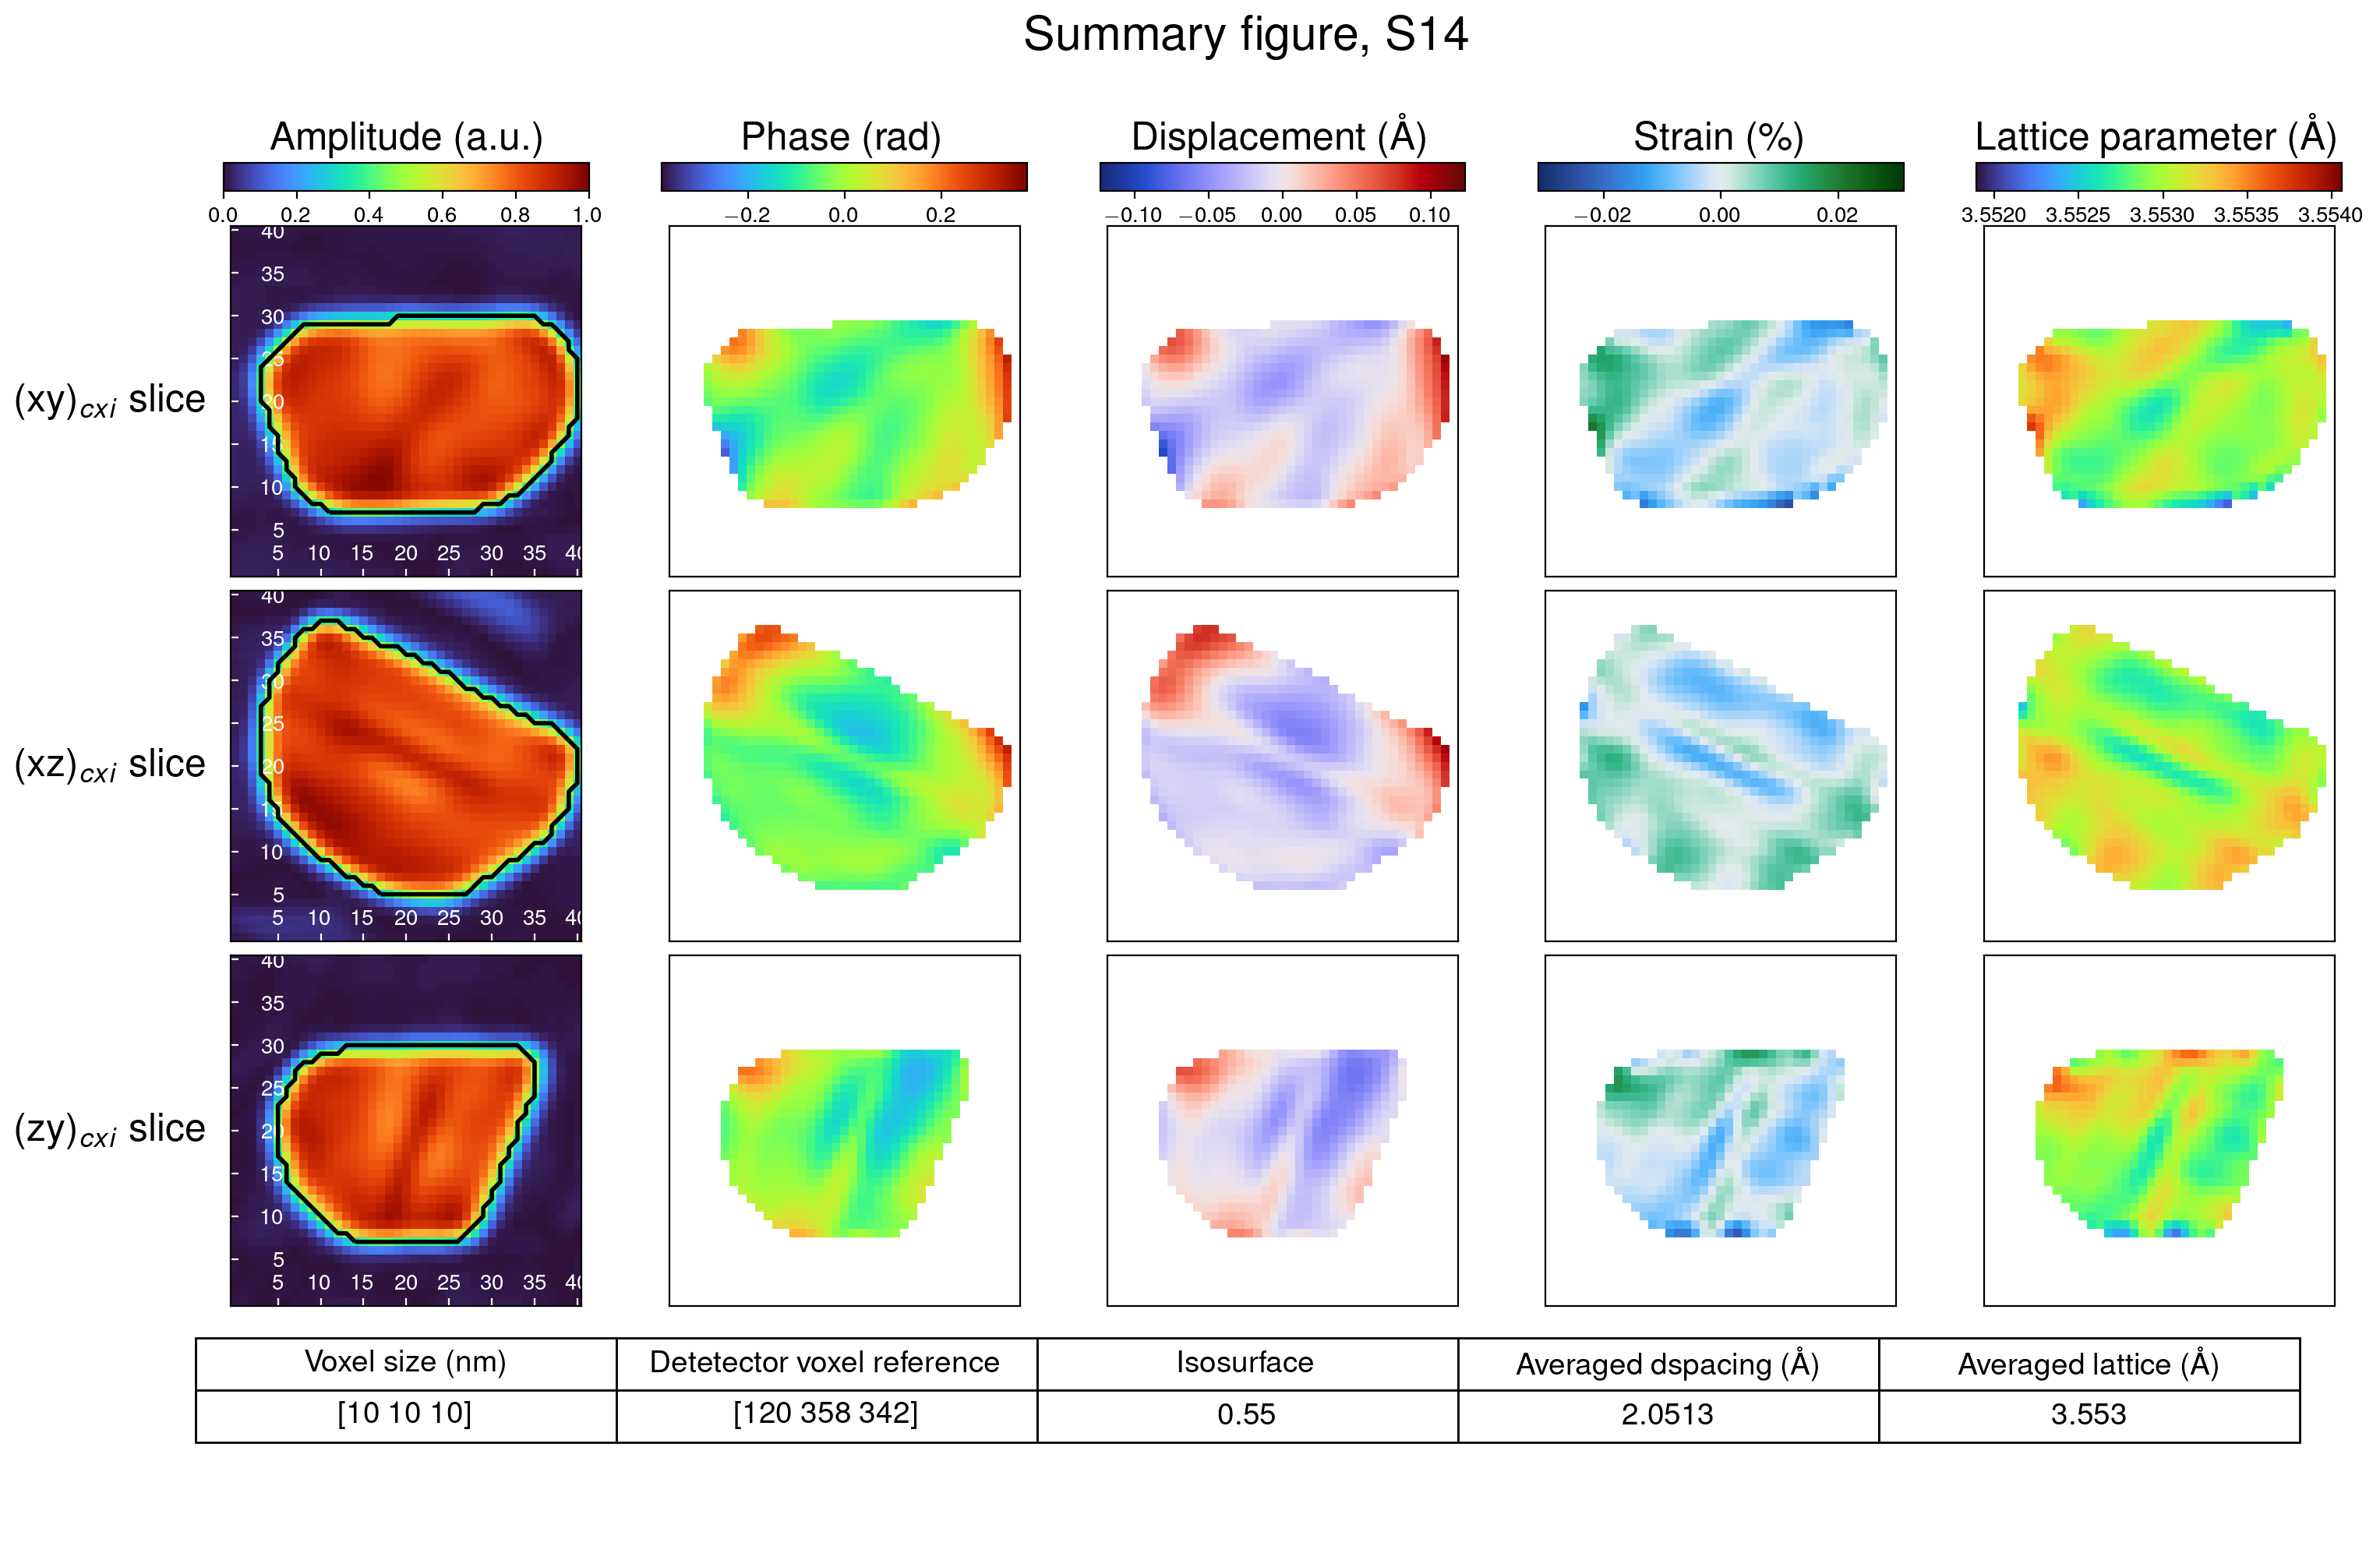

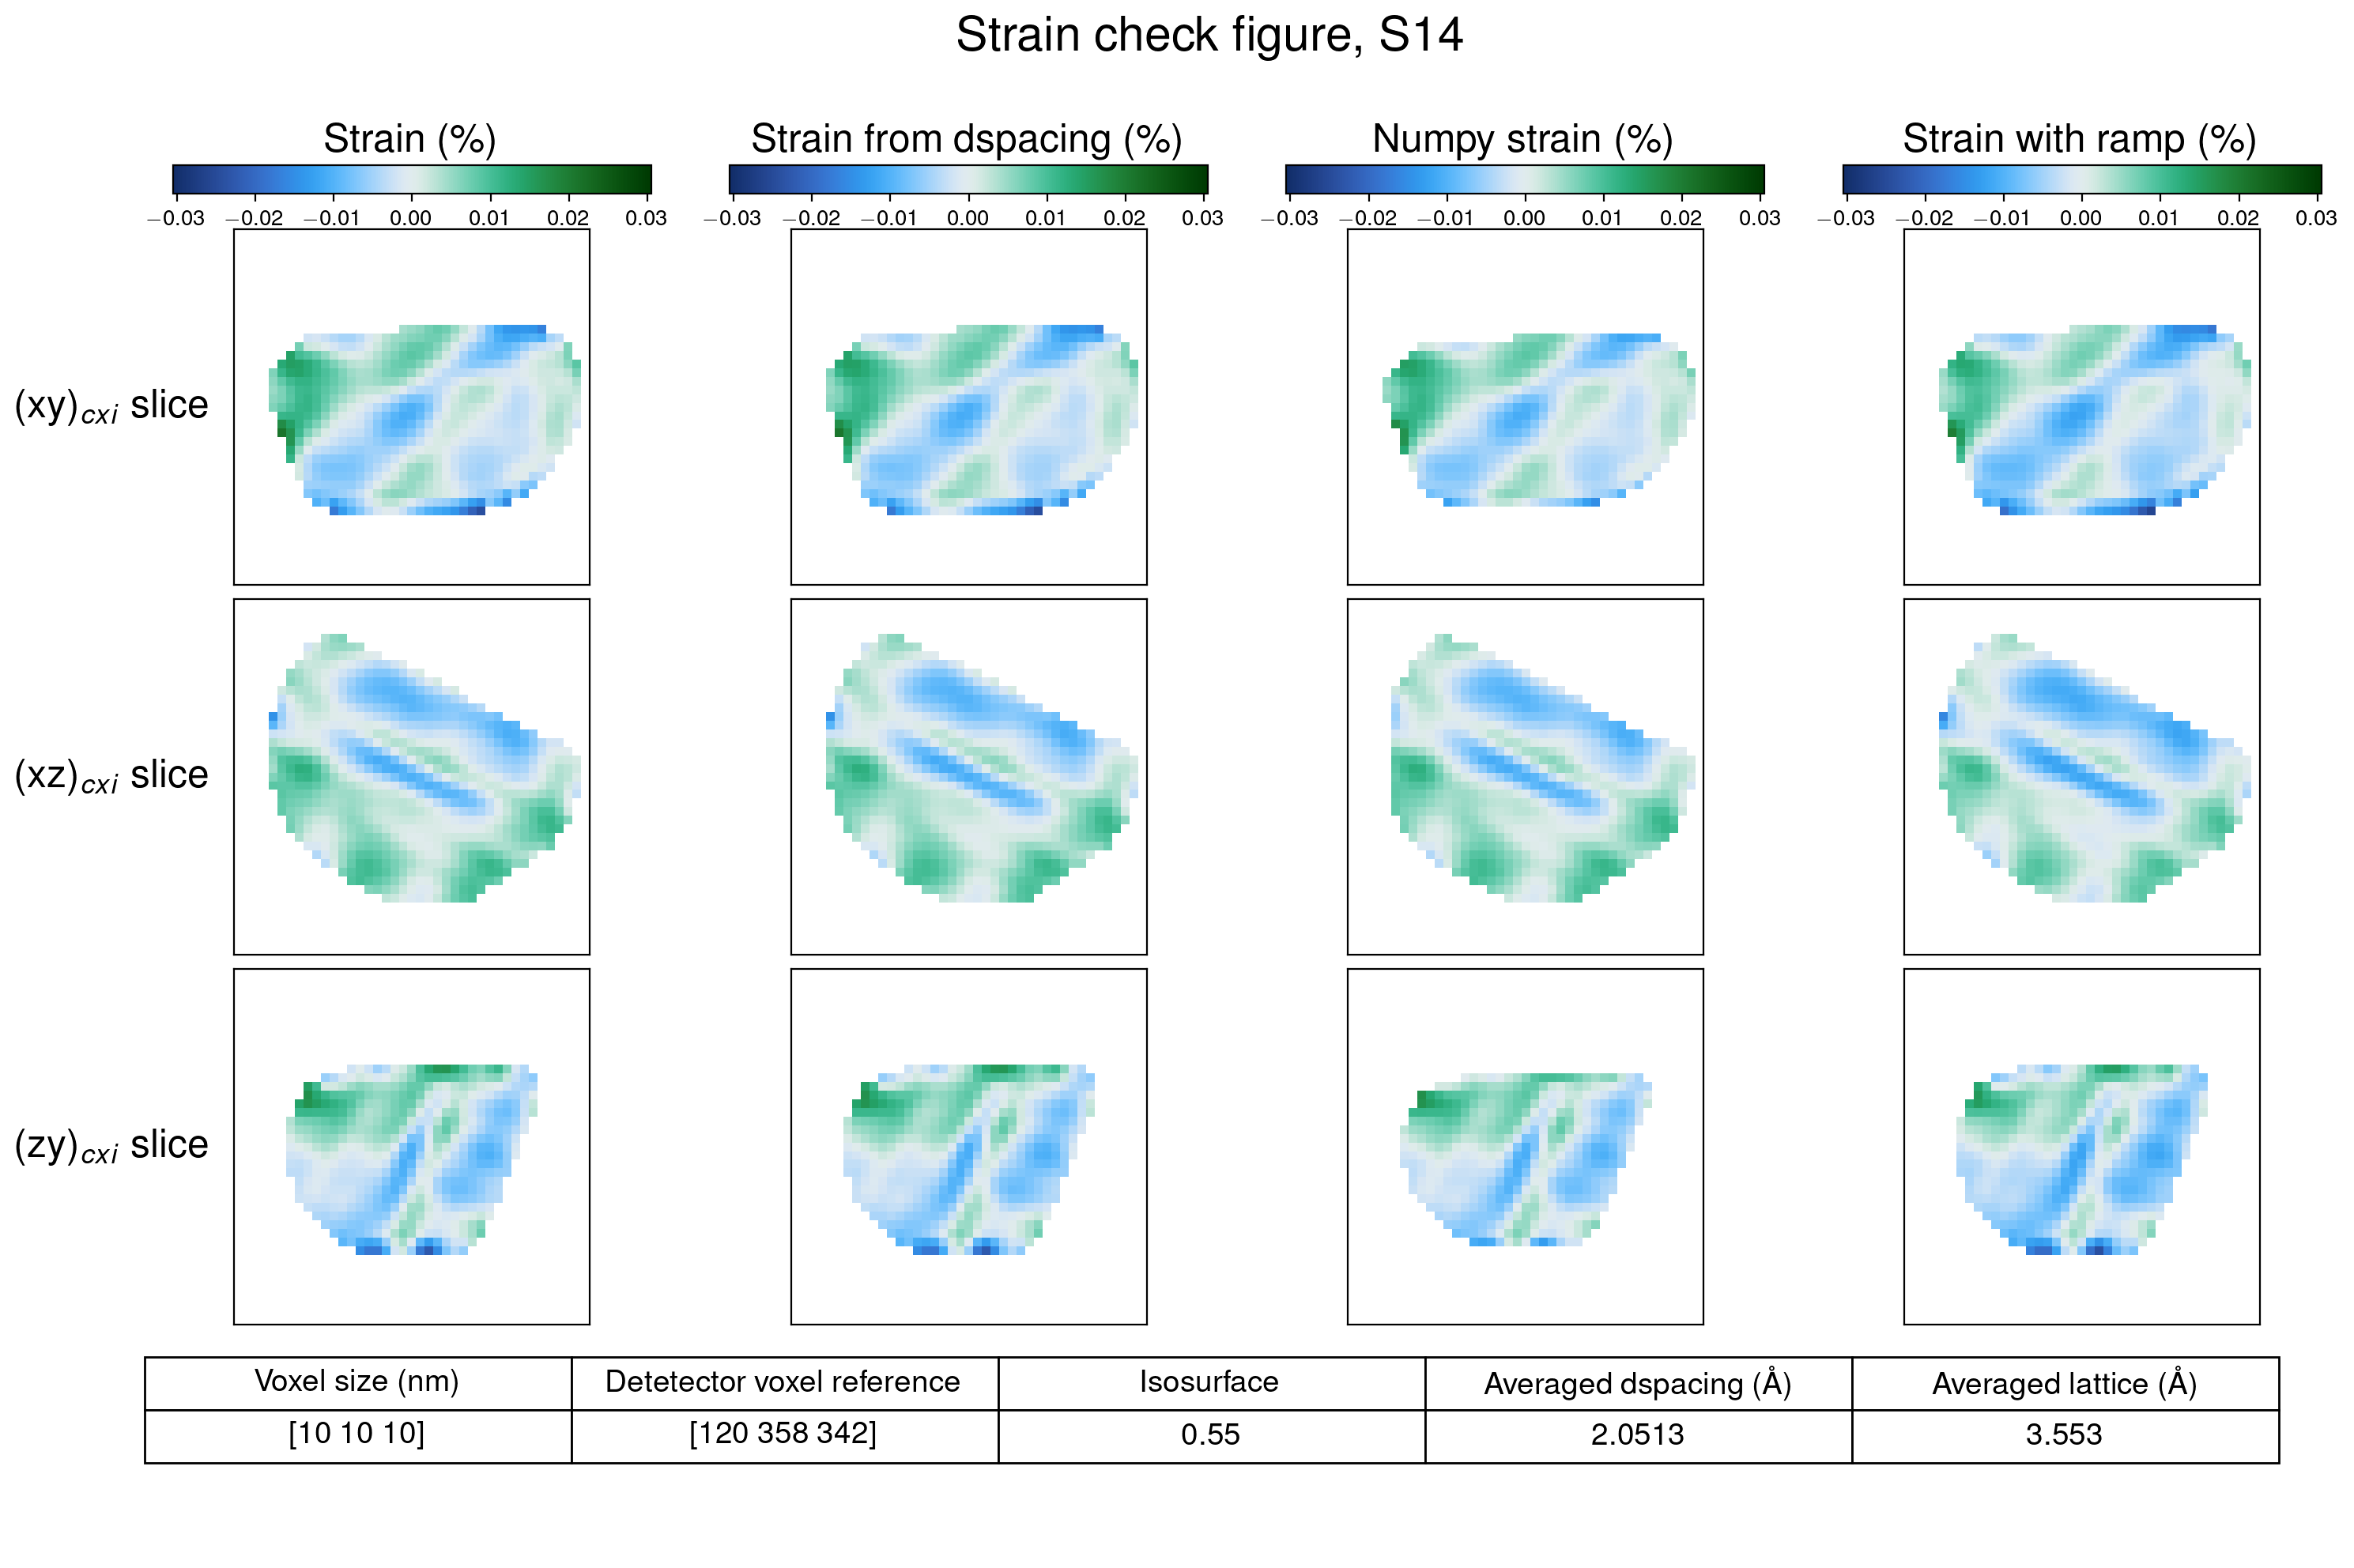

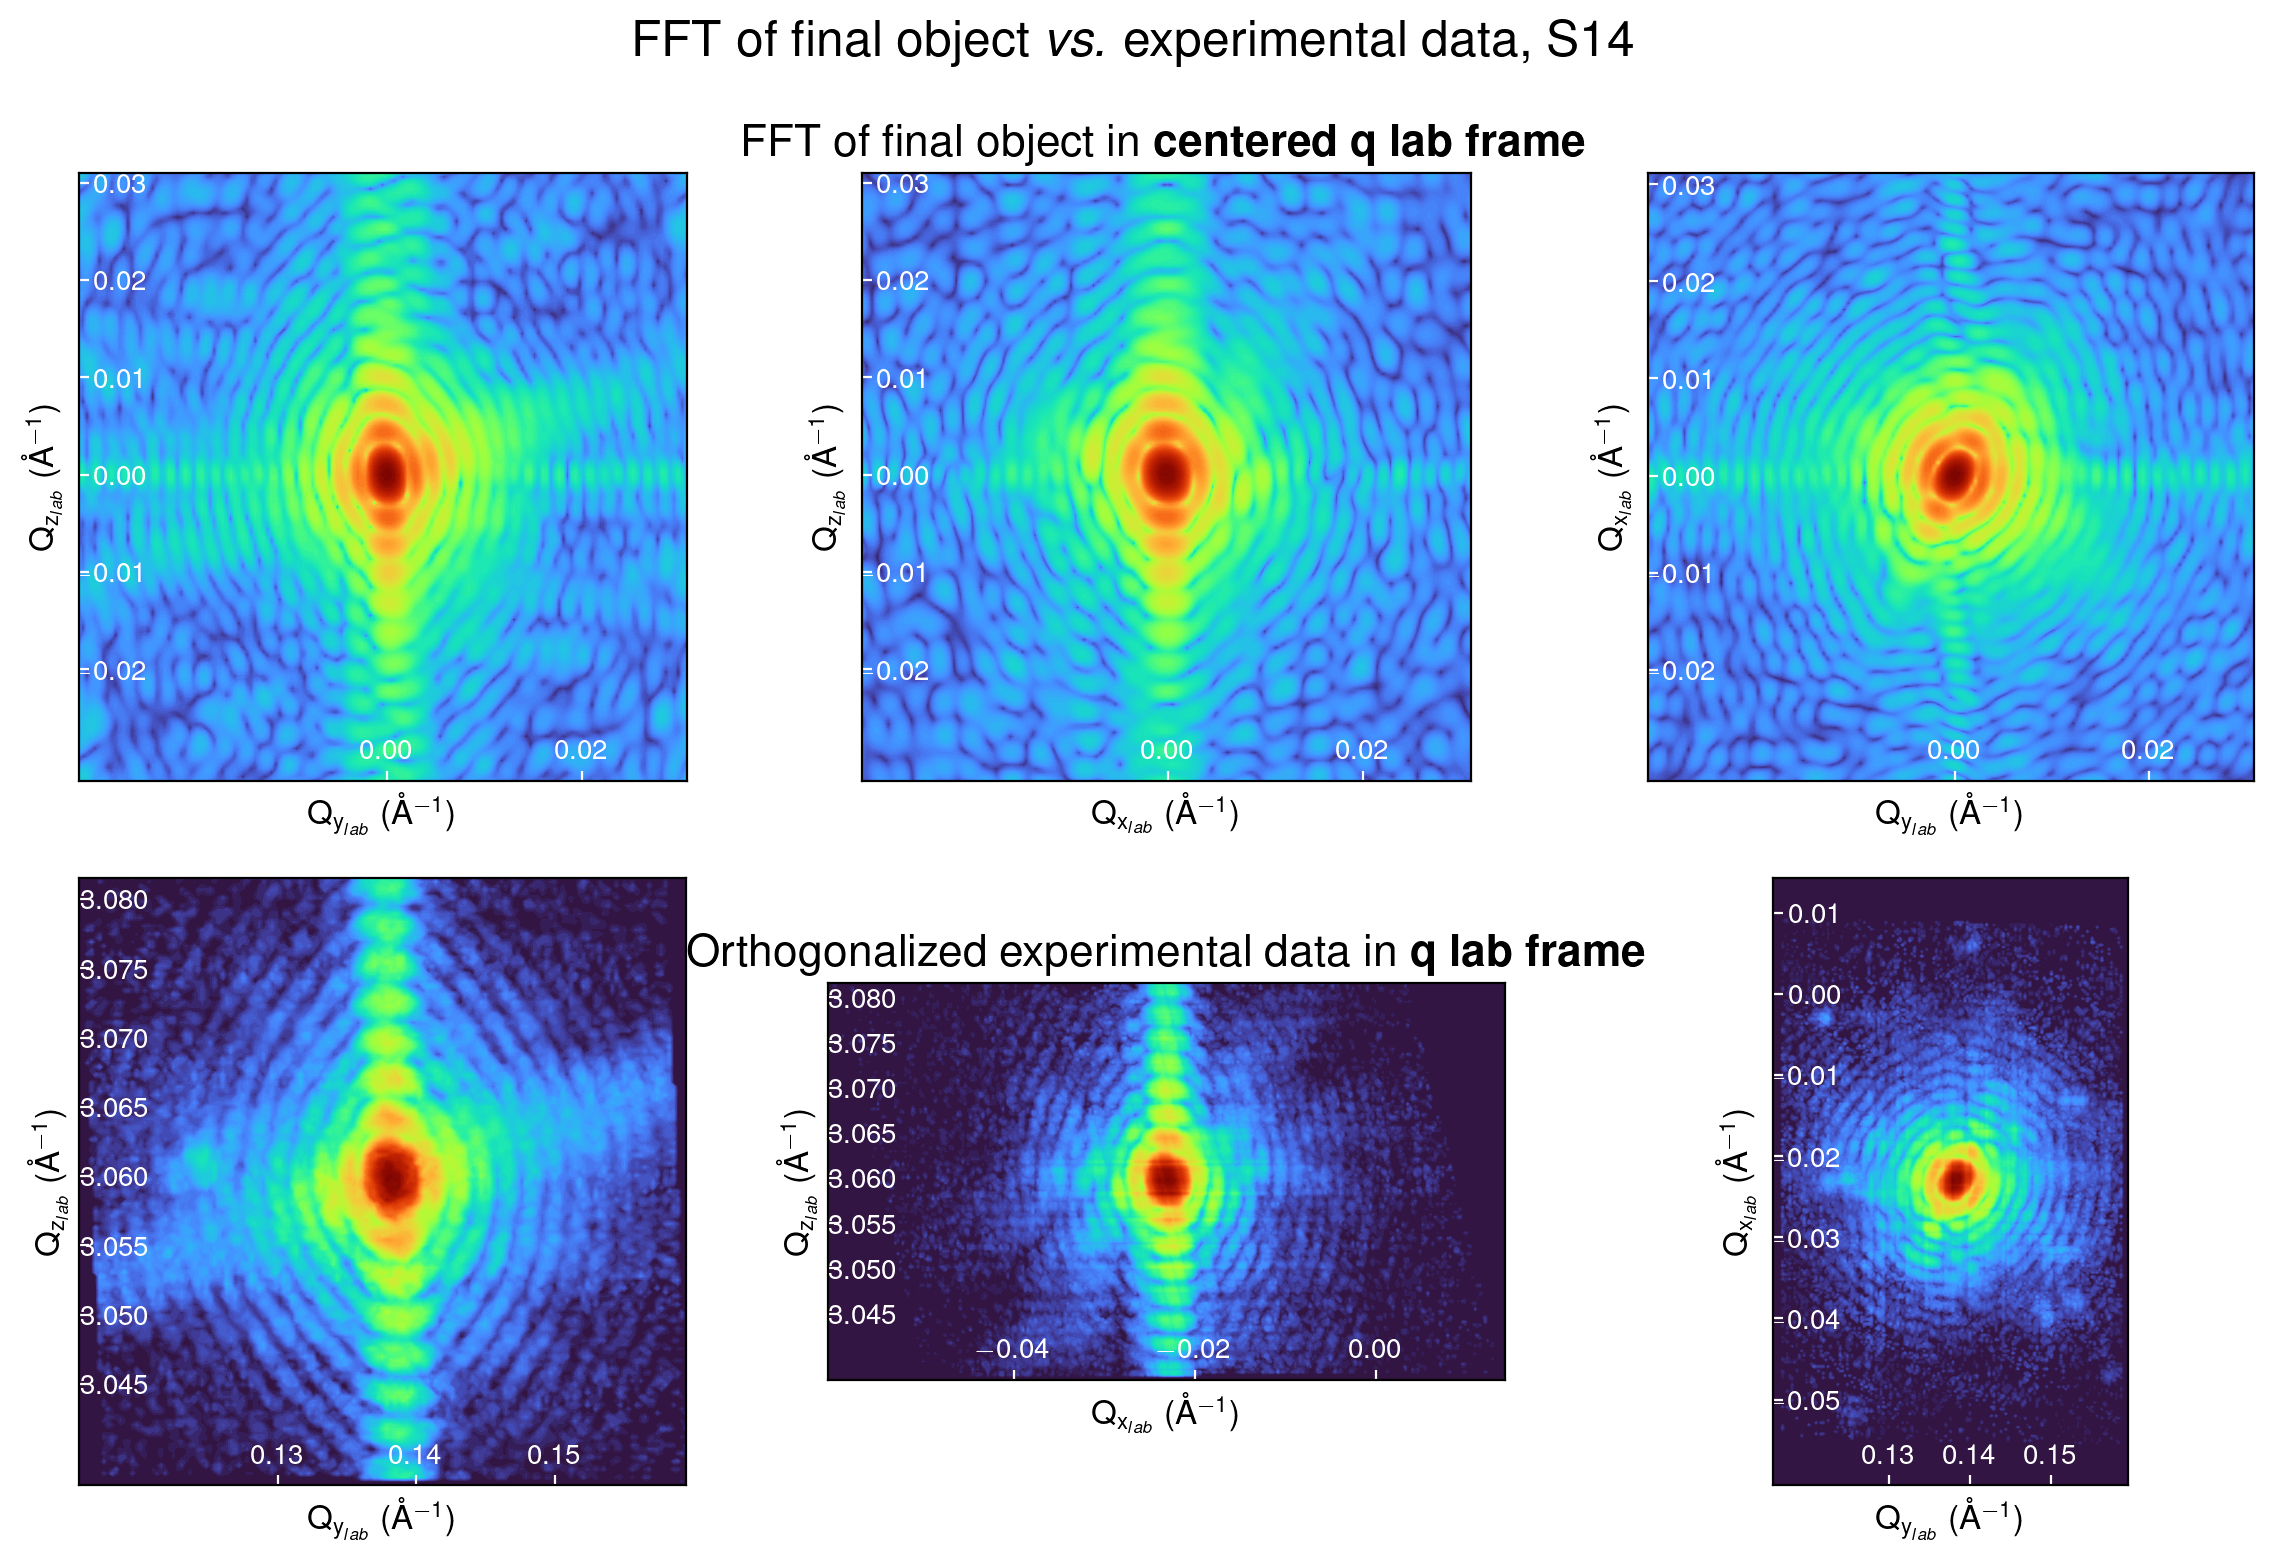


********************************************************************************
*Saving scan parameter file at the following location:
/data/id01/inhouse/clatlan/experiments/hc4959/analysis/results/B18S2P1_0005/S14/*
********************************************************************************



In [77]:
bcdi_pipeline.postprocess()